<a href="https://colab.research.google.com/github/BaraahAbuAbadi/Bike_Rides_in_SF_Part/blob/main/Bike_Rides_in_SF_Part_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pilot Project: Bike Rides in San Francisco
© 2024, Zaka AI, Inc. All Rights Reserved.


---


###**Case Study:** Analyzing & Forecasting the number of bike rides in San Francisco
**Objective:** The goal of this challenge is to let you dive deep into time-series signals, analyze it and determine the best predictive model.
The challenge is divided into 2 parts:

* **Part A:** You will use time-series data of the number of bike rides in San Fransisco and analyze it to better understand it and choose one of the statistical models you learned during the week to predict future values.

* **Part B:** You will prepare the same data and structure it in order to train an RNN to predict the number of bike rides for the next 7 days.


After you analyzed the time-series you're dealing with and tried to model it from a statistical approach, now you'll build a neural network to forecast the number of bike rides in the next seven days.



#Dataset Loading & Visualization
Let's start by importing the necessary libraries and the dataset.

In [1]:
# Test Your Zaka
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Dataset = pd.read_csv('/content/Bike Rides aggregated.csv')
Dataset.head()

,date,bike_numbers
0,2017-06-28,632
1,2017-06-29,1019
2,2017-06-30,1038
3,2017-07-01,475
4,2017-07-02,523


<Axes: xlabel='date'>

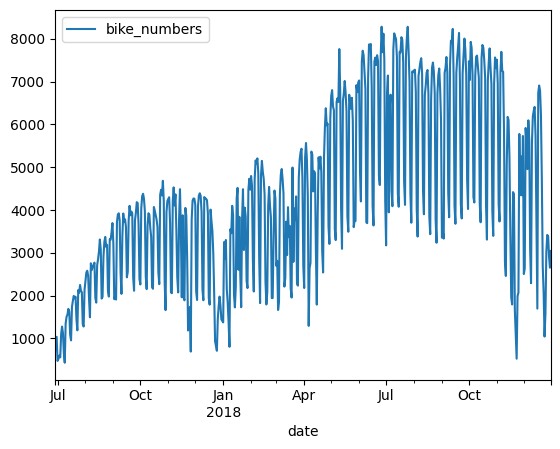

In [2]:
Dataset['date'] =  pd.to_datetime(Dataset['date'])
Dataset = Dataset.set_index('date')
Dataset.plot()

In [3]:
rows, cols = Dataset.shape
print(f'The dataset has {rows} rows and {cols} columns.')

The dataset has 552 rows and 1 columns.


In [4]:
Dataset.isnull().sum()

,0
bike_numbers,0


# Time-series Data Preparation

When dealing with a time-series forecasting task, it's important to start by asking: **How to resample the data?** days? months?

In your case, you're going to take the daily number of bike rides and predict the next 7 daily values so we don't need to resample our time-series.

The next step is to formulate the problem as follows:
**Given X, predict Y.**

Here, the question your model has to answer would be:
**Given the number of bike rides in the past week, what would be the number of bike rides in the next week?**


So you need to split your data between training and testing similar to any other ML task.

> **But Training & Testing samples are NOT randomly selected. Wait, what?!**

Unlike other datasets, we will not randomly select our test and train samples. We will divide our dataset into the most recent readings being training samples and the later readings testing samples.

This is because we are working on a prediction problem, and thus, the sequence in which data is presented matters!

Check the first and last day of the dataset

In [5]:
Dataset= Dataset/ Dataset.max()
Dataset

,bike_numbers
date,
2017-06-28,0.076310
2017-06-29,0.123038
2017-06-30,0.125332
2017-07-01,0.057353
2017-07-02,0.063149
...,...
2018-12-27,0.412702
2018-12-28,0.408838
2018-12-29,0.351123


**the first day is 2017-06-28 and the last day is 2018-12-31
 **


If we want one week ahead prediction, it makes sense to use the previous week of data to predict the week ahead.

To set this up properly, we would want our week to start on Monday and end on Sunday.

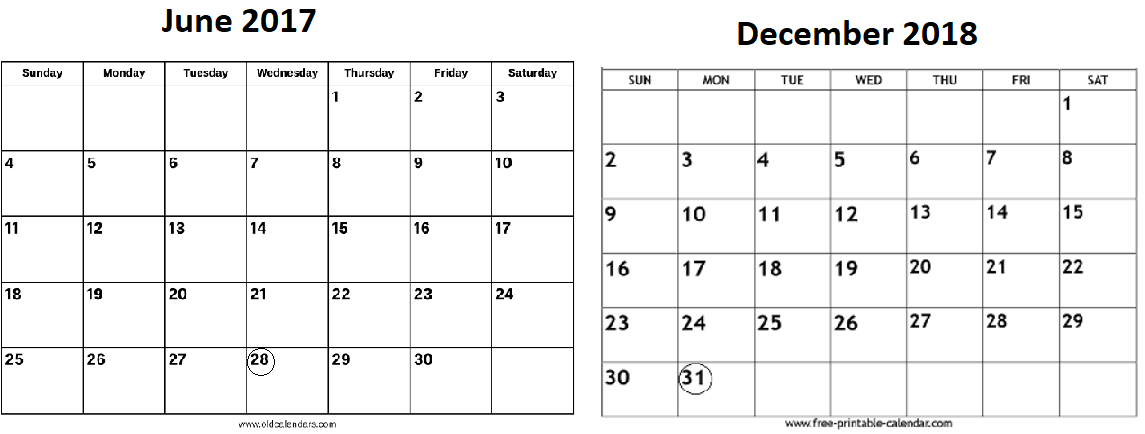

Filter your data and split it between training and testing.

**Hint: Your data should be structured as chunks of 7 days each**.

In [6]:
Filterd_dataset = Dataset.iloc[5:-1]
Filterd_dataset

,bike_numbers
date,
2017-07-03,0.072446
2017-07-04,0.067375
2017-07-05,0.133180
2017-07-06,0.154190
2017-07-07,0.135957
...,...
2018-12-26,0.365008
2018-12-27,0.412702
2018-12-28,0.408838


In [7]:
train, test = Filterd_dataset[0:385], Filterd_dataset[385:]

#reshape into windows of weekly data (one week = 7 days) (total days / 7 = total weeks)
train = np.array(np.split(train, len(train)/7))
test = np.array(np.split(test, len(test)/7))

print(f"The training set is {train.shape} and the test set is {test.shape}.")

The training set is (55, 7, 1) and the test set is (23, 7, 1).


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


So, now we have the training and testing sets. One more thing we need to prepare before moving to modeling is:

**How do we setup the data for supervised learning?** That is, what is my *X* and what is my *y*?

At each instant, we want to feed the model a week, and predict the week ahead.

We don't do this prediction for Mondays only; we do them for every day of the week.

Meaning, we want our input (X) and output (y) to look like:

```
[Input], [Output]
[d01, d02, d03, d04, d05, d06, d07], [d08, d09, d10, d11, d12, d13, d14]
Shift one day
[d02, d03, d04, d05, d06, d07, d08], [d09, d10, d11, d12, d13, d14, d15]
Etc ...
```
This helps to leverage the data that we have and mimic more data samples!

Create a function that:
- takes as input the dataset
- steps over the entire history one time step at a time
- returns X and Y as numpy arrays

This function will help you setup your task as a supervised learning problem.

In [8]:
#flatten the train data over all weeks
train = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
train.shape

(385, 1)

In [9]:
#flatten the test data over all weeks
test = test.reshape((test.shape[0]*test.shape[1], test.shape[2]))
test.shape


(161, 1)

In [49]:
def supervised_setup(data):
  x, y = [], []
  input_start =  0
  n_input = 7
  n_out =  7

  #step over the entire history one time step at a time
  for i in range (len(data)):
   input_end = input_start + n_input
   output_end = input_end + n_out

   if output_end <= len(data):
     x_input = data[input_start: input_end]
     x_input = x_input.reshape((len(x_input), 1))

     x.append(x_input)
     y.append(data[input_end:output_end])

   input_start +=1
  return np.array(x), np.array(y)



In [50]:
#split the data
x_train, y_train = supervised_setup(train)
x_test, y_test = supervised_setup(test)

# Model Building

**What is it that we want to predict?**

Here you should ask yourself the following questions:

- Is this task a univariate/multivariate forecasting?
- Will the model predict a signle step or is it a multi-step prediction problem?


**It is a univariate & multi-step prediction **

Now it's time to build your model and train it.

In [42]:
from keras.models import Sequential
from keras.layers import Dense
#We will run a long-short term Memory (LSTM) network since we are dealing with sequential data.
from keras.layers import LSTM


In [51]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(372, 7, 1) (372, 7, 1)
(148, 7, 1) (148, 7, 1)


In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

# Define input layer explicitly
model = Sequential([
    Input(shape=(n_inputs, n_channels)),  # Correct way to define input shape
    LSTM(n_cells, activation='relu'),
    Dense(n_neurons, activation='relu'),
    Dense(n_outputs)
])

# Compile and train
model.compile(optimizer='adam', loss='mse')
model.fit(x_train, y_train, epochs=70, batch_size=14, verbose=0)


# Evaluating Time-series model


### Walk-forward validation setup
Recall, we want our input (X) and output (y) to look like:

```
[Input], [Output]
[d01, d02, d03, d04, d05, d06, d07], [d08, d09, d10, d11, d12, d13, d14]
[d02, d03, d04, d05, d06, d07, d08], [d09, d10, d11, d12, d13, d14, d15]
Etc ...
```
This is how our setup will look like during evaluation:

```
Input          Predict         Observed History
Week0          Week1'          [Week0]
Week1          Week2'          [Week0+Week1]
Week2          Week3'          [Week0+Week1+Week2]
Week3          Week4'          [Week0+Week1+Week2+Week3]
```


Define a function that takes as input the trained model, historical data, and the number of inputs. This function will return the predicted number of bike rides for one upcoming week.

Then loop over the test set and use this function for forecasting.

In [56]:
#make a single prediction
def forecast(model, history, n_input):
  #flatten data & reshape into [1, n_input, 1]
  input_x = np.array(history).reshape((1, n_input,1))

  #forcast the next week
  predicted_y = model.predict(input_x, verbose= 0)

  #we only want the vector forecast
  predicted_y = predicted_y[0]
  return predicted_y

In [58]:
#To start evaluating our model, we can start from the last week in our training data
previous_week = x_train[-1, :]
n_input = 7

#we do walk-forward validation for each week
predictions = []
for i in range(len(x_test)):
  #predict the Week
  y_predicted = forecast(model, previous_week, n_input)
  #collect predictions
  predictions.append(y_predicted)
  #get real observation and add it to my history
  previous_week = x_test[i,:]


### Model Evaluation

Calculate overall RMSE for the entire week

In [59]:
from sklearn.metrics import mean_squared_error

#now, we want to evaluate our model
predictions = np.array(predictions)

#But we want to see how our model is doing day by day
scores = []
#calculate an RMSE score for each day
for i in range(y_test.shape[1]):
  mse = mean_squared_error(y_test[:, i], predictions[:, i])
  rmse = np.sqrt(mse)
  scores.append(rmse)

weekly_score = np.array(scores).mean()


[AVG]['mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun'] 
 [0.216][0.19190205861051554, 0.2523599855065591, 0.20303633368536786, 0.19844788492181584, 0.20704129705332538, 0.22069030600470704, 0.23876433440624656]


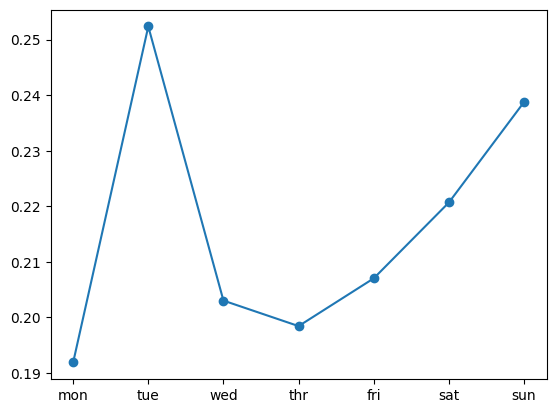

In [60]:
days = ['mon', 'tue', 'wed','thr', 'fri', 'sat', 'sun']
print('[AVG]%s \n [%.3f]%s'%(days, weekly_score, scores))

plt.plot(days, scores, marker='o', label='lstm')
plt.show()

In [61]:
#sorting observations and model outputs in daatframes
true = pd.DataFrame(y_test[:,0])
pred = pd.DataFrame(predictions[:,0])

In [62]:
Filterd_dataset.iloc[385]

,2018-07-23
bike_numbers,0.913306


### Visual validation of model performance: Predictions versus Observations

- Print and plot the overall score of the predictions
- Overlay observed sequence and predicted sequence

In [65]:
#creating a datetime index for the dataframes
dti = pd.date_range('2018-07-23', periods=161, freq='D')

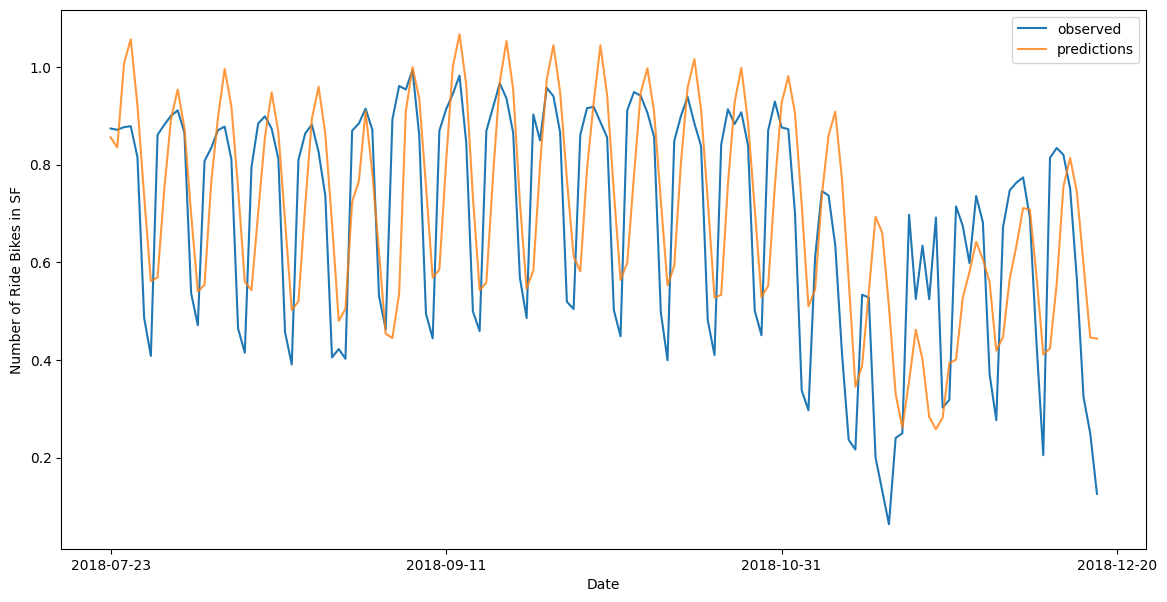

In [66]:
# Overlay observed sequence and predicted sequence
ax = true.plot()
pred.plot(ax=ax, alpha=0.8, figsize=(14, 7))

xi = list(range(len(dti)))
plt.xticks(np.arange(min(xi), max(xi), 50), dti.date[np.arange(min(xi), max(xi), 50)])

ax.set_xlabel('Date')
ax.set_ylabel('Number of Ride Bikes in SF')
plt.legend(['observed', 'predictions'])
plt.show()